In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

%matplotlib inline

## Подготовка данных

In [58]:

def read_data(filename, is_test):
 
    # читаем данные из csv
    df = pd.read_csv(filename, index_col='match_id')

    if not is_test:
        # удаляем неиспользуемые поля "будущего"
        df.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1, inplace=True)

    # заполняем пропуски значением 0
    df.fillna(0, inplace=True)

    # количество объектов
    n_samples = df.shape[0]
    
    # количество героев
    n_heroes = df.r1_hero.max()
    if not is_test:
        print('heroes: %d' % n_heroes)
        
    # разворачиваем коды героев в "мешок слов"
    X_pick = np.zeros((n_samples, n_heroes))
    for i, match_id in enumerate(df.index):
        for p in range(5):
            X_pick[i, df.ix[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
            X_pick[i, df.ix[match_id, 'd%d_hero' % (p + 1)] - 1] = -1

    # удаляем категорные поля        
    df.drop(['lobby_type'], axis=1, inplace=True)

    # удаляем поля кодов героев, которые мы развернули в "мешок слов"
    df.drop(['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero', ], axis=1, inplace=True)
        
    if not is_test:
        # данные машинного обучения
        X = df.drop('radiant_win', axis=1).values
        y = df.radiant_win.values
    else:
        X = df.values
        
    # прицепляем "мешок слов" героев
    X = np.hstack([X, X_pick])
    
    if not is_test:
        return X, y
    else:
        return X
    

X, y = read_data('features.csv', is_test=False)
X_test = read_data('features_test.csv', is_test=True)

heroes: 112


## Код

In [8]:
# обертка для тестирования различных классификаторов
def meter(make_clf, params, n_folds=5, scoring='roc_auc'):
    
    # фиксируем разбиение для cross-validation
    kf = KFold(n_samples, n_folds=n_folds, shuffle=True, random_state=42)
    
    # собираем значения метрик
    scores = []
    
    # собираем длительности вычислений
    durations = []
    
    # проходим по всем параметрам
    for param in params:
        
        # создаем классификатор с тестируемым параметром
        clf = make_clf(param)
        
        # засекаем время начала вычислений
        start = datetime.now()
        
        # кросс-валидация
        score = cross_val_score(clf, X, y, scoring=scoring, cv=kf, n_jobs=-1)
        
        # длительность вычислений
        durations.append(datetime.now() - start)
        
        # среднее по разбиению кросс-валидации
        scores.append(score.mean())
        
    # оформляем результаты в виде DataFrame
    return pd.DataFrame({'score': scores, 'duration': durations}, index=params)

## Градиентный бустинг

In [4]:
def make_clf_gb(n_estimators):
    gb = GradientBoostingClassifier(n_estimators=n_estimators)
    return gb

df = meter(make_clf_gb, [10, 30, 50, 70, 100])
df.index.name = 'estimators'
df

,duration,score
estimators,,
10,00:01:03.695705,0.664851
30,00:02:52.452918,0.689894
50,00:04:49.721425,0.698924
70,00:05:40.446836,0.706640
100,00:08:15.516466,0.714160


## Логистическая регрессия

In [5]:
def make_clf_lr(C):
    scaler = StandardScaler()
    lr = LogisticRegression('l2', C=C)
    return make_pipeline(scaler, lr)

df = meter(make_clf_lr, [0.001, 0.01, 0.1, 1.0, 10.0])
df.index.name = 'C'
df

,duration,score
C,,
0.001,00:00:09.579059,0.751612
0.010,00:00:12.481195,0.751964
0.100,00:00:13.442301,0.751930
1.000,00:00:12.842198,0.751925
10.000,00:00:12.965783,0.751925


## Прогноз на тестовой выборке

In [55]:
clf = make_clf_lr(C=0.01)
clf.fit(X, y)
pred = clf.predict_proba(X_test)
pred = pred[:, 1]

In [56]:
print('min: %f' % pred.min())
print('max: %f' % pred.max())

min: 0.008491
max: 0.996278


## Гистограммы вероятностей

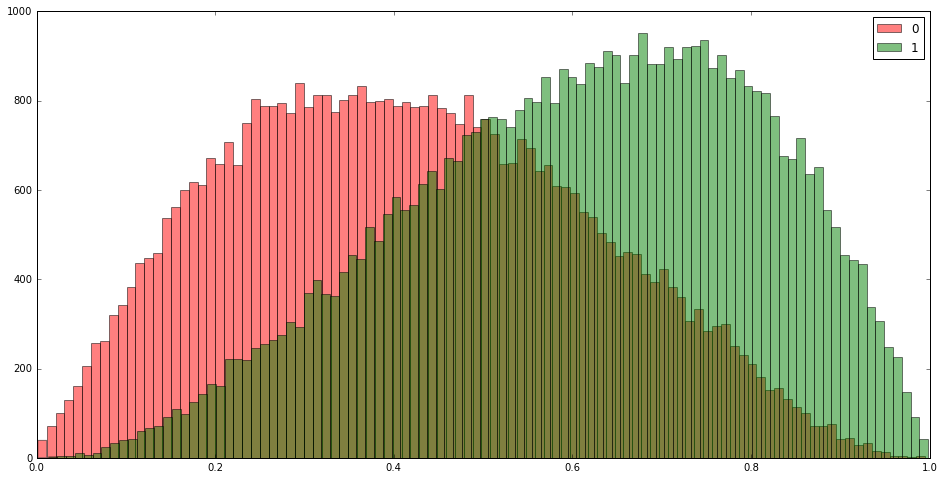

In [57]:
import matplotlib.pyplot as plt

p = clf.predict_proba(X)
p = p[:, 1]

p0 = p[y == 0];
p1 = p[y == 1];

plt.figure(figsize=(16, 8))
plt.hist(p0, bins=100, alpha=0.5, color='r', label='0');
plt.hist(p1, bins=100, alpha=0.5, color='g', label='1');
plt.legend()

## Ближайшие соседи

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def make_clf_kn(n):
    scaler = StandardScaler()
    kn = KNeighborsClassifier(n_neighbors=n)
    return make_pipeline(scaler, kn)

df = meter(make_clf_kn, [10, 50, 100, 500, 1000])
df.index.name = 'neighbors'
df

,duration,score
neighbors,,
10,00:24:57.801411,0.600004
50,00:24:14.140372,0.658736
100,00:23:55.225709,0.678708
500,00:27:03.477065,0.702821
1000,00:24:06.839795,0.704886
